In [1]:
pip install scikit-surprise

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

import string 
import datetime
import gzip

from sklearn import preprocessing
from textblob import TextBlob

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split

from surprise.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [4]:
url_review = '/content/drive/My Drive/Data/steam_reviews.json.gz'
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 15
for l in parse(url_review):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

data_reviews = pd.DataFrame(data_reviews)

In [5]:
url_games = '/content/drive/My Drive/Data/steam_games.json.gz'
data_games = []
for l in parse(url_games):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

https://towardsdatascience.com/steam-recommendation-systems-4358917288eb

https://ansegura7.github.io/RS_Surprise/pages/RS_SVD.html

# Parte A Procesamiento de datos

## Reviews

In [6]:
data_reviews.head(4)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Duha Nubie,11.3,73.0,35140,4,2018-01-03,first debut feel sweet,False,1,NaN,NaN,NaN
2,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
3,S0YxSauCe,0.3,902.0,671270,4,2017-07-10,Easy game. All you have to do is put the hat t...,False,1,NaN,NaN,NaN


In [7]:
data_reviews.shape

(519538, 12)

In [8]:
data_reviews.dtypes

username         object
hours           float64
products        float64
product_id       object
page_order        int64
date             object
text             object
early_access       bool
page              int64
user_id          object
compensation     object
found_funny     float64
dtype: object

In [9]:
#Elimino columnas
data_reviews.drop(['page_order', 'page',
                   'early_access', 'compensation', 'found_funny',
                   'products', 'user_id'],
                   axis=1, inplace=True)

In [10]:
#Convertir a string columnas
columnas = ['username', 'text']
for i in columnas:
  data_reviews[i] = data_reviews[i].astype('string')

#Convertir a int64 columna product_id
data_reviews['product_id'] = data_reviews['product_id'].astype('int64')

#Conversion a tipo datetime64
data_reviews['Fecha'] = pd.to_datetime(data_reviews['date'])
data_reviews['Year'] = data_reviews['Fecha'].dt.year            #Nueva columna con el año del review
data_reviews['month'] = data_reviews['Fecha'].dt.month          #Nueva columna con el mes del review

In [11]:
#Elimino reviews duplicadas del mismo usuario para el mismo videojuego, dejando la mas reciente
data_reviews.drop_duplicates(subset=['username', 'product_id'], keep='first', inplace=True)

In [12]:
def valores_nulos(data):
  print('<-- Porcentaje de valores nulos -->\n')
  print(data.isnull().sum() / data.shape[0] * 100)

In [13]:
valores_nulos(data_reviews)

<-- Porcentaje de valores nulos -->

username      0.000000
hours         0.341593
product_id    0.000000
date          0.000000
text          0.000000
Fecha         0.000000
Year          0.000000
month         0.000000
dtype: float64


 ## Info Games

In [14]:
data_games.shape

(32135, 16)

In [15]:
data_games.dtypes

publisher          object
genres             object
app_name           object
title              object
url                object
release_date       object
tags               object
discount_price    float64
reviews_url        object
specs              object
price              object
early_access         bool
id                 object
developer          object
sentiment          object
metascore          object
dtype: object

In [16]:
#Elimino valores nulos
data_games.dropna(subset=['tags', 'id', 'title'], axis=0, inplace=True)

In [17]:
#Convertir a string columnas
columnas = ['genres', 'title','tags']
for i in columnas:
  data_games[i] = data_games[i].astype('string')

#Convertir a int64 columna product_id
data_games['id'] = data_games['id'].astype('int64')

In [18]:
data_games.drop(['publisher','reviews_url', 'url', 
                 'early_access', 'discount_price', 
                 'app_name', 'release_date',
                 'discount_price', 'specs', 
                 'sentiment', 'metascore'],
                axis=1,
                inplace=True)

In [19]:
valores_nulos(data_games)

<-- Porcentaje de valores nulos -->

genres       3.666076
title        0.000000
tags         0.000000
price        4.103867
id           0.000000
developer    4.087157
dtype: float64


In [20]:
#Tranferencia del Nombre del videojuego segun su id
df = pd.merge(data_reviews, data_games,  left_on='product_id', right_on='id')
df.head(3)

,username,hours,product_id,date,text,Fecha,Year,month,genres,title,tags,price,id,developer
0,Chaos Syren,0.1,725280,2017-12-17,This would not be acceptable as an entertainme...,2017-12-17,2017,12,"['Action', 'Adventure', 'Indie', 'Simulation']",Psi Project,"['Action', 'Adventure', 'Indie', 'Simulation']",2.99,725280,Vyacheslav Shilikhin
1,Duha Nubie,11.3,35140,2018-01-03,first debut feel sweet,2018-01-03,2018,1,"['Action', 'Adventure']",Batman: Arkham Asylum Game of the Year Edition,"['Action', 'Batman', 'Stealth', 'Adventure', '...",19.99,35140,"Rocksteady Studios,Feral Interactive (Mac)"
2,MLGarbage,9.5,35140,2018-01-02,Fun Game. I played shadow of mordor before pla...,2018-01-02,2018,1,"['Action', 'Adventure']",Batman: Arkham Asylum Game of the Year Edition,"['Action', 'Batman', 'Stealth', 'Adventure', '...",19.99,35140,"Rocksteady Studios,Feral Interactive (Mac)"


##Exploración de Información

In [21]:
print('Un total de {} usuarios realizaron reviews de videojuegos'.format(len(df.username.unique())))

Un total de 388027 usuarios realizaron reviews de videojuegos


In [22]:
print("<-- Top 10 Usuarios con mas reviews -->")
df.username.value_counts().head(10)

<-- Top 10 de Usuarios con mas reviews -->


Alex           119
Nick            99
Jack            96
Chris           85
Saint Aaron     76
Dan             76
123             74
Kodyd194        73
Sam             71
Matt            71
Name: username, dtype: Int64

In [23]:
print('<-- Videojuegos con mas Reviews -->\n')
df.title.value_counts().head(10)

<-- Videojuegos con mas Reviews -->



Team Fortress 2                11731
Rust                            6623
Borderlands 2                   4733
Fallout 4                       4454
Grand Theft Auto V              3901
Portal 2                        3678
Undertale                       3659
DayZ                            3625
Warframe                        3553
Life is Strange - Episode 1     3345
Name: title, dtype: Int64

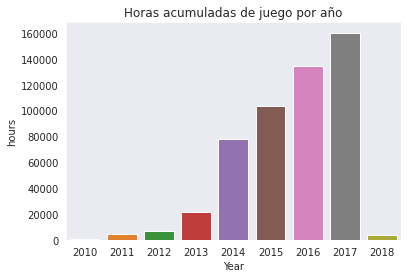

In [24]:
year_review = df.groupby(['Year']).count()
plt.title('Horas acumuladas de juego por año')
sns.barplot(x = year_review.index,
            y=year_review.hours)

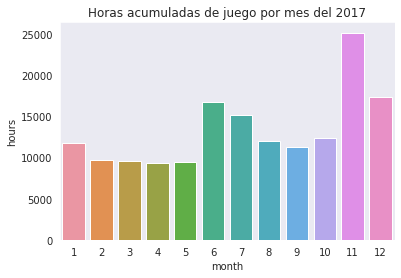

In [25]:
months_2017 = df[df['Year'] == 2017].groupby(['month']).count()
plt.title('Horas acumuladas de juego por mes del 2017')
sns.barplot(x= months_2017.index,
            y=months_2017.hours)

In [26]:
print('<-- Desarrolladores con mas videojuegos registrados -->\n')
data_games.developer.value_counts().head(10)

<-- Desarrolladores con mas videojuegos registrados -->



Ubisoft - San Francisco       1259
SmiteWorks USA, LLC            813
Dovetail Games                 253
KOEI TECMO GAMES CO., LTD.     232
Paradox Development Studio     156
Capcom                         130
Ronimo Games                   123
Choice of Games                100
Musopia                         95
Stainless Games                 95
Name: developer, dtype: int64

In [27]:
print('<-- Desarrolladores con mas reviews -->\n')
df.developer.value_counts().head(10)

<-- Desarrolladores con mas reviews -->



Valve                                       24337
Facepunch Studios                            9733
Bohemia Interactive                          7662
Bethesda Game Studios                        6963
Gearbox Software,Aspyr (Mac &amp; Linux)     4733
Ubisoft Montreal                             4707
Hi-Rez Studios                               4128
Daybreak Game Company                        4051
Rockstar North                               3947
Digital Extremes                             3804
Name: developer, dtype: int64

Text(0, 0.5, 'Frecuencia')

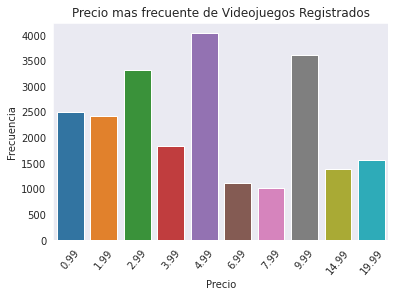

In [28]:
price_games = data_games.price.value_counts().head(10)
sns.barplot(x=price_games.index[0:],
            y=price_games)
plt.title('Precio mas frecuente de Videojuegos Registrados')
plt.xticks(rotation=50)
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

Text(0, 0.5, 'Frecuencia')

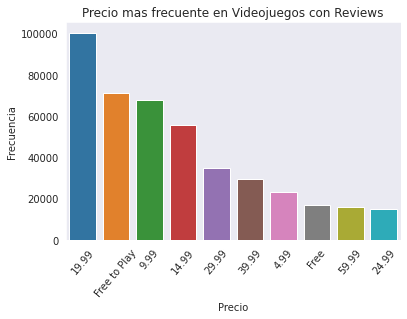

In [29]:
price_games = df.price.value_counts().head(10)
sns.barplot(x=price_games.index[0:],
            y=price_games)
plt.title('Precio mas frecuente en Videojuegos con Reviews')
plt.xticks(rotation=50)
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

In [30]:
break

SyntaxError: ignored

# Procesamiento de Lenguaje Natural

Realizo procesamiento de lenguaje, para intentar obtener una calificacion a la review realizada por el usuario , obteniendo una calificacion para la polaridad del comentario.
Si el comentario es positivo, el valor sera igual o cercano a 1, mientras, que, si el comentario es negativo, el valor sera igual o cercano a -1, si el comentario es neutro el valor sera cercano o igual a 0

In [31]:
df.drop(['hours', 'date', 'Fecha', 'Year', 'month', 'developer', 'price','id'], axis=1, inplace=True)

In [32]:
 #Elimino signos de puntuacion
 df['xtext'] = df['text'].str.replace('[{}]'.format(string.punctuation), ' ')

## Conversion de nombre de usuarios a numeros

In [33]:
le = preprocessing.LabelEncoder()
le.fit(df['username'])
df['x_username'] = le.transform(df['username'])

df.head(2)

,username,product_id,text,genres,title,tags,xtext,x_username
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,"['Action', 'Adventure', 'Indie', 'Simulation']",Psi Project,"['Action', 'Adventure', 'Indie', 'Simulation']",This would not be acceptable as an entertainme...,45116
1,Duha Nubie,35140,first debut feel sweet,"['Action', 'Adventure']",Batman: Arkham Asylum Game of the Year Edition,"['Action', 'Batman', 'Stealth', 'Adventure', '...",first debut feel sweet,73962


In [34]:
#Submuestra
df_sub= df.sample(frac=0.1)
df_sub.reset_index(drop=True, inplace=True)

## Emojis

In [ ]:
pip install emoji

In [ ]:
#Elimino cualquier emoji presente en la review escrita
import emoji

In [ ]:
df_reviews.xtext.iloc[1]

In [ ]:
#df_reviews['xtext'] = emoji.demojize(df_reviews['xtext'])

## Traduccion de comentario

In [ ]:
#df_reviews['xtext'] = df_reviews['text'].apply(lambda x: TextBlob(x).translate(to='en'))

In [ ]:
#Ya que todos los comentarios se encuentran en ingles, la celda anterior marca error, ya que no tiene acciones por realizar

## Polaridad y subjetividad de reviews

In [ ]:
#Correcion de escritura
#correciones = []
#for i in range(df_sub.shape[0]):
#  correcion = df_sub.xtext.iloc[i]
#  correcion = TextBlob(correcion).correct()
#  correciones.append(correcion)
#df_sub['xtext'] = correciones

In [ ]:
#TextBlob(comentario).sentimen

In [35]:
#Creacion de una nueva columna con la polaridad de la review
comentarios = []

for i in range(df_sub.shape[0]):
  comentario = df_sub.xtext.iloc[i]
  comentario = TextBlob(comentario).polarity
  comentarios.append(comentario)

df_sub['polarity'] = comentarios

In [36]:
#Creacion de una nueva columna con la subjetividad de la revoew
comentarios = []

for i in range(df_sub.shape[0]):
  comentario = df_sub.xtext.iloc[i]
  comentario = TextBlob(comentario).subjectivity
  comentarios.append(comentario)

df_sub['subjectivity'] = comentarios

## Analisis de comentarios

In [38]:
#Data de videojuego con el promedio de polaridad en sus reviews
ratings = pd.DataFrame(df_sub.groupby('title')['polarity'].mean())
ratings.head()

,polarity
title,
#monstercakes,0.077500
$1 Ride,-0.137500
&gt;observer_,0.140639
- Arcane RERaise -,0.400000
- Occult RERaise -,-0.191667


In [41]:
print('<-- Videojuegos con más reviews positivas-->\n')
ratings.sort_values(by='polarity', ascending=False).head(10)

<-- Videojuegos con más reviews positivas-->



,polarity
title,
Heart of Crown PC,1.00
Animal Super Squad,1.00
The Great War 1918,1.00
Blood Feed,1.00
QUAKE III: Team Arena,1.00
DRAGON BALL Xenoverse 2 - Steve Aoki Pack,1.00
Substance Painter 2,1.00
Spikit,1.00
Kick-Ass,1.00


In [43]:
#Nueva columna, el numero de reviews recibidas por videojuego
ratings['num_of_ratings'] = pd.DataFrame(df_sub.groupby('title')['polarity'].count())
ratings.head()

,polarity,num of ratings,num_of_ratings
title,,,
#monstercakes,0.077500,1,1
$1 Ride,-0.137500,1,1
&gt;observer_,0.140639,1,1
- Arcane RERaise -,0.400000,1,1
- Occult RERaise -,-0.191667,1,1


Text(0.5, 1.0, "Polaridad de Review's")

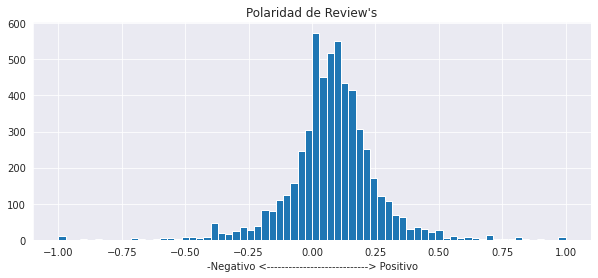

In [45]:
plt.figure(figsize=(10,4))
ratings['polarity'].hist(bins=70)
plt.xlabel('-Negativo <----------------------------> Positivo')
plt.title("Polaridad de Review's")

# Modelo benchmark
Sistema de Recomendación basado en la la polaridad de la review

In [46]:
df_sub.drop(columns=['text'], inplace=True)

In [47]:
gamemat = df_sub.pivot_table(index='username',columns='title',values='polarity')
gamemat.head()

title,#monstercakes,$1 Ride,&gt;observer_,- Arcane RERaise -,- Occult RERaise -,.hack//G.U. Last Recode,//N.P.P.D. RUSH//- The milk of Ultraviolet,//SNOWFLAKE TATTOO//,001 Game Creator,0RBITALIS,10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,1001 Spikes,12 Labours of Hercules,12 Labours of Hercules II: The Cretan Bull,12 Labours of Hercules III: Girl Power,12 Labours of Hercules V: Kids of Hellas (Platinum Edition),12 is Better Than 6,140,16bit Trader,18 Wheels of Steel: Convoy,18 Wheels of Steel: Extreme Trucker,1849,1917 - The Alien Invasion DX,1943 Megami Strike,1953 - KGB Unleashed,1979 Revolution: Black Friday,199X,1HEART,2 Ninjas 1 Cup,200% Mixed Juice!,2064: Read Only Memories,20XX,24 HOURS,28 Waves Later,30 IMPOSSIBLE LEVELS,3030 Deathwar Redux,3089 -- Futuristic Action RPG,...,emoj.io,eversion,fault - milestone one,fault - milestone two side:above,flChess,gravilon,hack_me,hack_me 2,hackmud,hocus,how do you Do It?,iBomber Defense Pacific,iFactor,iO,ibb &amp; obb,inMomentum,klocki,kuso,liquivid Video Improve,liteCam Game 5: 120 FPS Game Capture + Streamer,liteCam Game: 100 FPS Game Capture,nail'd,oO,panGEMic,planetarian ~the reverie of a little planet~,rFactor 2,realMyst: Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter Classic,theHunter: Call of the Wild™,theHunter: Primal,ШП,侠客风云传(Tale of Wuxia),家有大貓 Nekojishi,東方天空璋 ～ Hidden Star in Four Seasons.,神明的一天世界(God's One Day World),軒轅劍外傳穹之扉(The Gate of Firmament)
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
! Monika !,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!#ChatOff_I Got It<3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!FT!Marauder - In-Game - LIFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!Mr.A<3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!WiingzZ!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
#Elimino videojuegos con menos de 20 reviews
gamemat = gamemat.dropna(thresh=30, axis=1).fillna(0,axis=1)

In [49]:
corrMatrix = gamemat.corr(method='pearson')
corrMatrix.head(5)

title,100% Orange Juice,A Story About My Uncle,A.V.A. Alliance of Valiant Arms™,ABZU,APB Reloaded,ARK: Survival Evolved,ASTRONEER,Absolver,Ace of Spades: Battle Builder,AdVenture Capitalist,Age of Empires II HD,Age of Empires® III: Complete Collection,Alan Wake,Alien Swarm,Alien: Isolation,Aliens vs. Predator™,America's Army: Proving Grounds,American Truck Simulator,Amnesia: The Dark Descent,Antichamber,Arma 2: Operation Arrowhead,Arma 3,Assassin's Creed® Origins,Assassin's Creed® Unity,Assassin’s Creed® III,Assassin’s Creed® IV Black Flag™,Aura Kingdom,Awesomenauts - the 2D moba,BLOCKADE 3D,Banished,Bastion,Batman: Arkham Asylum Game of the Year Edition,Batman™: Arkham Knight,Batman™: Arkham Origins,BattleBlock Theater®,Battleborn,Battlefield: Bad Company™ 2,Battlerite,BeamNG.drive,BioShock™,...,The Witcher 2: Assassins of Kings Enhanced Edition,Thief,This War of Mine,Thomas Was Alone,To the Moon,Tom Clancy's Rainbow Six® Siege,Tom Clancy’s Splinter Cell Blacklist,Torchlight II,Total War™: ROME II - Emperor Edition,Town of Salem,Train Simulator,Transformice,Transistor,Tree of Savior (English Ver.),Tribes: Ascend,Trine 2: Complete Story,Tropico 4,Trove,Undertale,Unturned,VA-11 Hall-A: Cyberpunk Bartender Action,VVVVVV,Vampire: The Masquerade - Bloodlines,Verdun,WARMODE,Wallpaper Engine,Warface,Warframe,Wargame: Red Dragon,Warhammer: End Times - Vermintide,Watch_Dogs® 2,Who's Your Daddy,WildStar,Wolfenstein II: The New Colossus,Wolfenstein: The New Order,World of Guns: Gun Disassembly,XCOM: Enemy Unknown,XCOM® 2,theHunter Classic,theHunter: Call of the Wild™
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100% Orange Juice,1.000000,-0.000110,-0.000014,-0.000131,-0.000063,-0.000041,-0.000054,-0.000080,-0.000008,-0.000047,-0.000162,-0.000101,-0.000120,-0.000075,-0.000077,-0.000039,-0.000059,-0.000128,-0.000030,-0.000093,-0.000097,-0.000210,-0.000099,-0.000059,-0.000039,-0.000117,-0.000075,-0.000133,-0.000035,-0.000158,-0.000206,-0.000109,-0.000077,-0.000100,-0.000088,-0.000009,-0.000138,-0.000140,-0.000099,-0.000136,...,-0.000130,-0.000054,-0.000066,-0.000110,-0.000139,-0.000158,-0.000077,-0.000181,-0.000082,-0.000071,-0.000035,-8.421852e-07,-0.000171,-0.000045,-0.000081,-0.000110,-0.000054,-0.000126,-0.000201,-0.000155,-0.000100,-0.000050,-0.000099,-0.000117,-0.000060,-0.000186,-0.000086,-0.000262,-0.000065,-0.000096,-0.000050,-0.000008,-0.000081,-0.000117,-0.000133,-0.000024,-0.000162,-0.000091,0.000071,-0.000048
A Story About My Uncle,-0.000110,1.000000,-0.000033,-0.000320,-0.000155,-0.000101,-0.000134,-0.000197,-0.000019,-0.000116,-0.000396,-0.000247,-0.000295,-0.000185,-0.000189,-0.000095,-0.000145,-0.000313,-0.000075,-0.000227,-0.000238,-0.000514,-0.000243,-0.000145,-0.000097,-0.000288,-0.000183,-0.000327,-0.000087,-0.000388,-0.000505,-0.000269,-0.000190,-0.000245,-0.000216,-0.002836,-0.000340,-0.000344,-0.000244,-0.000335,...,-0.000320,-0.000132,-0.000161,-0.000271,-0.000340,-0.000387,-0.000189,-0.000445,-0.000202,-0.000175,-0.000087,-2.065867e-06,-0.000419,-0.000110,-0.000199,-0.000270,-0.000133,-0.000310,-0.000493,-0.000381,-0.000245,-0.000122,-0.000243,-0.000288,-0.000146,-0.000456,-0.000211,-0.000643,-0.000158,-0.000236,-0.000122,-0.000019,-0.000199,-0.000288,-0.000327,-0.000060,-0.000398,-0.000223,0.000175,-0.000117
A.V.A. Alliance of Valiant Arms™,-0.000014,-0.000033,1.000000,-0.000039,-0.000019,-0.000012,-0.000016,-0.000024,-0.000002,-0.000014,-0.000049,-0.000030,-0.000036,-0.000023,-0.000023,-0.000012,-0.000018,-0.000038,-0.000009,-0.000028,-0.000029,-0.000063,-0.000030,-0.000018,-0.000012,-0.000035,-0.000022,-0.000040,-0.000011,-0.000048,-0.000062,-0.000033,-0.000023,-0.000030,-0.000027,-0.000003,-0.000042,-0.000042,-0.000030,-0.000041,...,-0.000039,-0.000016,-0.000020,-0.000033,-0.000042,-0.000048,-0.000023,-0.000055,-0.000025,-0.000022,-0.000011,-2.541762e-07,-0.000052,-0.000014,-0.000024,-0.000033,-0.000016,-0.000038,-0.000061,-0.000047,-0.000030,-0.000015,-0.000030,-0.000

In [50]:
def get_similar(game_name,rating):
    similar_ratings = corrMatrix[game_name]*(rating-2.5)
    similar_ratings = similar_ratings.sort_values(ascending=False)
    #print(type(similar_ratings))
    return similar_ratings

In [ ]:
games = [("Call of Duty®: Modern Warfare® 2",0.6),("Battlefield: Bad Company™ 2",1)]
similar_games = pd.DataFrame()
for game,rating in games:
    similar_games = similar_games.append(get_similar(game,rating),ignore_index = True)

similar_games.head(10)

In [ ]:
similar_games.sum().sort_values(ascending=False).head(20)

In [51]:
def get_random_game():
  all_games = data_games[['id', 'title']]
  #Selecciona un usuario al azar
  x = int(np.random.randint(df_sub.shape[0], size=1))
  x = df_sub.username.iloc[x]
  usuario = df[df['username'] == x]
  print('--> El usuario ha jugado: ',usuario.shape[0], 'videojuegos')
  #Elimino titulos que el usuario ya ha jugado
  for i in usuario.title:
    game = i
    all_games.drop(all_games[all_games['title'] == game ].index, inplace=True)
    
  #Obtengo un titulo al azar
  game = df_sub.title.iloc[int(np.random.randint(df_sub.shape[0], size=1))]
  print(' * Videjuego seleccionado:', game)

  #Solicito al usuario escriba su review(Tiene que ser en ingles) para analizar su polaridad
  rating = str(input('--> Ingrese la review del videojuego: '))
  rating = TextBlob(rating).polarity

  #Obtengo titulos con polaridades similares
  similar_games = pd.DataFrame()
  similar_games = similar_games.append(get_similar(game,rating),ignore_index = True)
  x = similar_games.sum().sort_values(ascending=False).head(10)

  #Elimino los juegos que el usuario ya ha jugado
  for i in x.index:
    name = i
    usuario.drop(usuario[usuario['title'] == name ].index, inplace=True)

  print('<------------------------->')
  print("Nuestra recomendaciones para usted: \n")
  for i in x.index:
    print(i)

In [54]:
get_random_game()

--> El usuario ha jugado:  5 videojuegos
 * Videjuego seleccionado: Sid Meier's Civilization® V
--> Ingrese la review del videojuego: the best game ever
<------------------------->
Nuestra recomendaciones para usted: 

Skullgirls
Dying Light
Borderlands 2
Team Fortress 2
Portal 2
Warframe
Kerbal Space Program
Starbound
Arma 3
Bastion


Falta emplear un dataframe en donde solo se encuentren los viejuegos con reviews mayores a 30 aparciciones

# Machine Learning
## Surprise

In [55]:
#Creo una copia de las review, que mas adelante empleare
calificaciones = df_sub[['x_username', 'product_id', 'polarity']]

In [56]:
calificaciones.head(2)

,x_username,product_id,polarity
0,13671,221100,-0.101786
1,98910,346110,0.200000



###Intento nuevo

https://ansegura7.github.io/RS_Surprise/pages/RS_SVD.html

In [57]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(calificaciones, test_size = 0.2, random_state=40)

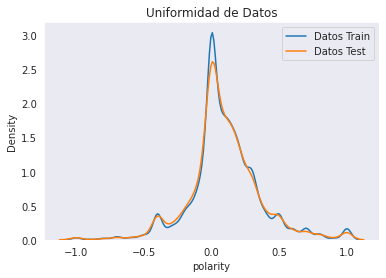

In [58]:
sns.kdeplot(train_data['polarity'], label='Datos Train')
sns.kdeplot(test_data['polarity'], label='Datos Test')
plt.title('Uniformidad de Datos')
plt.legend()

In [59]:
reader = Reader(rating_scale = (-1.00, 1.00))
data_train = Dataset.load_from_df(train_data[['x_username', 'product_id', 'polarity']], reader)
data_test = Dataset.load_from_df(test_data[['x_username', 'product_id', 'polarity']], reader)

In [60]:
# Build full trainset
data_train = data_train.build_full_trainset()
data_test = data_test.build_full_trainset()

In [61]:
print('Train rating', data_train.global_mean)
print('Test rating', data_test.global_mean)

Train rating 0.0998507128014436
Test rating 0.09326409004789389


In [62]:
# Create the trainset and testset
data_trainset = data_train.build_testset()
data_testset = data_test.build_testset()

In [63]:
# Create SVD 
from surprise import SVD
algo = SVD()

In [64]:
#algo = SVD(n_factors= 5, n_epochs= 200, biased= True, lr_all= 0.005, reg_all= 0, init_mean= 0, init_std_dev= 0.01)

In [65]:
#Entreno el modelo
algo.fit(data_train)

In [66]:
# Calculate RMSE for training dataset
from surprise import accuracy
train_pred = algo.test(data_trainset)
accuracy.rmse(train_pred)

RMSE: 0.2033


0.20329187332645962

In [67]:
# Calculate RMSE for test dataset
test_pred = algo.test(data_testset)
accuracy.rmse(test_pred)

RMSE: 0.2628


0.26282600670367195

In [69]:
train_data.head(2)

,x_username,product_id,polarity
514,360690,377160,0.000000
26020,58605,327410,0.008333


In [68]:
# Prediccion con datos de entrenamiento
p1 = algo.predict(uid = train_data.iloc[0].x_username, iid = train_data.iloc[0].product_id, verbose = True)

user: 360690.0   item: 377160.0   r_ui = None   est = 0.11   {'was_impossible': False}


In [70]:
train_data.head(4)

,x_username,product_id,polarity
514,360690,377160,0.000000
26020,58605,327410,0.008333
16314,130865,440,0.350000
16497,119262,327030,0.009387


In [71]:
test_data.x_username.value_counts().head(5)

84936     3
228320    3
34028     3
13616     3
15040     3
Name: x_username, dtype: int64

In [72]:
#Selecciono al usuario con aparicion
usuario = test_data[test_data['x_username'] == 84936]
usuario

,x_username,product_id,polarity
14774,84936,220200,-0.066667
48610,84936,237930,0.350000
45966,84936,49520,0.450000


In [73]:
usuario['estimate_escore'] = usuario['product_id'].apply(lambda x: algo.predict(uid = usuario.x_username.iloc[0],iid = x).est)
usuario

,x_username,product_id,polarity,estimate_escore
14774,84936,220200,-0.066667,0.195443
48610,84936,237930,0.350000,0.166887
45966,84936,49520,0.450000,0.228527


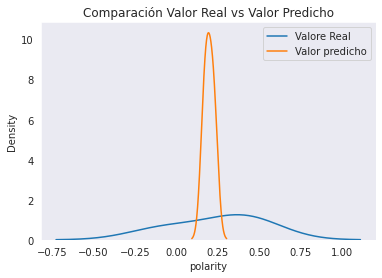

In [74]:
sns.kdeplot(usuario['polarity'], label='Valore Real')
sns.kdeplot(usuario['estimate_escore'], label='Valor predicho')
plt.title('Comparación Valor Real vs Valor Predicho')
plt.legend()

In [ ]:
# Prediction with real rating
p2 = algo.predict(uid = 34028, iid = 303210, r_ui = 0.100000, verbose = True)

## Optimizacion de Hyperparametros

In [78]:
reader = Reader(rating_scale = (-1.00, 1.00))
data = Dataset.load_from_df(calificaciones[['x_username', 'product_id', 'polarity']], reader)

In [76]:
#n_factors= k_factors, n_epochs= 200, biased= True, lr_all= 0.005, reg_all= 0, init_mean= 0, init_std_dev= 0.01

In [79]:
param_grid = {
    'n_factors': [5,10,15],
    'n_epochs' : [100,150,200],
    'lr_all'   : [0.002, 0.005],
    'reg_all'  : [0, 0.002, 0.02],
    'biased'   : [True],
    'init_mean': [0],
    'init_std_dev': [0.01]
    }
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs = -1)
gs.fit(data)

In [80]:
gs.best_params

{'rmse': {'biased': True,
  'init_mean': 0,
  'init_std_dev': 0.01,
  'lr_all': 0.002,
  'n_epochs': 100,
  'n_factors': 15,
  'reg_all': 0.02}}

In [81]:
print("Mejores parametros : "+str(gs.best_params))
print("Mejor Score : "+str(gs.best_score)+'\n')

Mejores parametros : {'rmse': {'n_factors': 15, 'n_epochs': 100, 'lr_all': 0.002, 'reg_all': 0.02, 'biased': True, 'init_mean': 0, 'init_std_dev': 0.01}}
Mejor Score : {'rmse': 0.2622640808032842}



In [82]:
#Establecer modelo con los hyperparametros 
algo = SVD(n_factors = 15, n_epochs= 100, biased= True, lr_all= 0.002, reg_all= 0.02, init_mean= 0, init_std_dev= 0.01)

In [83]:
#Entrenar modelo
algo.fit(data_train)

In [84]:
#Nuevas predicciones
usuario['new_estimate_escore'] = usuario['product_id'].apply(lambda x: algo.predict(uid = usuario.x_username.iloc[0],iid = x).est)
usuario

,x_username,product_id,polarity,estimate_escore,new_estimate_escore
14774,84936,220200,-0.066667,0.195443,0.150003
48610,84936,237930,0.350000,0.166887,0.193649
45966,84936,49520,0.450000,0.228527,0.188289


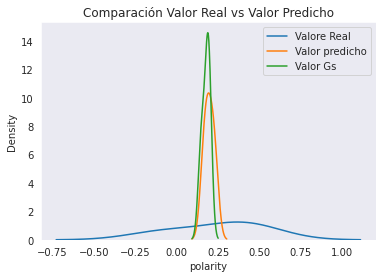

In [85]:
sns.kdeplot(usuario['polarity'], label='Valore Real')
sns.kdeplot(usuario['estimate_escore'], label='Valor predicho')
sns.kdeplot(usuario['new_estimate_escore'], label='Valor Gs')
plt.title('Comparación Valor Real vs Valor Predicho')
plt.legend()

In [86]:
df_sub.head(2)

,username,product_id,genres,title,tags,xtext,x_username,polarity,subjectivity
0,Alex Wagner,221100,"['Action', 'Indie', 'Massively Multiplayer', '...",DayZ,"['Early Access', 'Survival', 'Zombies', 'Open ...",I cant understand peoples tardism a this point...,13671,-0.101786,0.541964
1,Gopnik Slav,346110,"['Action', 'Adventure', 'Indie', 'Massively Mu...",ARK: Survival Evolved,"['Survival', 'Dinosaurs', 'Open World', 'Multi...",Giving a thumbs up because I got it for 27 eur...,98910,0.200000,0.600000


In [87]:
def games_top_predict():
  all_games = data_games[['id', 'title']]
  #Seleccion de usuario al azar
  x = int(np.random.randint(df_sub.shape[0], size=1))
  x = df_sub.username.iloc[x]
  usuario = df[df['username'] == x]
  print('Usuario seleccionado: {}'.format(usuario.iloc[0].username))
  print('--> El usuario ha jugado: ',usuario.shape[0], 'videojuegos')

  #Elimino videojuegos jugados
  for i in usuario.title:
    game = i
    all_games.drop(all_games[all_games['title'] == game ].index, inplace=True)
  
  #Seleccion de videojuego al azar
  game = df_sub.title.iloc[int(np.random.randint(df_sub.shape[0], size=1))]
  print(' * Videjuego seleccionado:', game)
  input('--> Ingrese la review del videojuego: ')

  #Prediccion
  all_games['estimate_escore'] = all_games['id'].apply(lambda x: algo.predict(uid = usuario.x_username.iloc[0],iid = x).est)

  top = all_games.sort_values(ascending=False, by='estimate_escore').head(5)
  print('\n Nuestra recomendacion de Videojuegos :\n')
  for i in top['title']:
    print('---> ', i)

In [88]:
games_top_predict()

Usuario seleccionado: dodgyticker
--> El usuario ha jugado:  1 videojuegos
 * Videjuego seleccionado: Garry's Mod
--> Ingrese la review del videojuego: Best game ever

 Nuestra recomendacion de Videojuegos :

--->  Aseprite
--->  Tom Clancy's Splinter Cell Chaos Theory®
--->  Source Filmmaker
--->  Defense Grid: The Awakening
--->  Cry of Fear


# Recomendaciones

Este sistema de recomendación se basa en la similitud del genero del videojuego del cual se realiza la review

In [89]:
#Submuestra
df_games = data_games.sample(frac=0.04)
df_games.reset_index(drop=True, inplace=True)

df_reviews = data_reviews.sample(frac=0.04)
df_reviews.reset_index(drop=True, inplace=True)

In [90]:
 #df_games['tags'] = df_games['tags'].fillna(' ')
 df_games['xtags'] = df_games['tags'].str.replace('[{}]'.format(string.punctuation), ' ')

In [91]:
stopwords = nltk.corpus.stopwords.words('english')        #Defino las stopwords
tfidf = TfidfVectorizer(stop_words=set(stopwords))        #Defino el modelo
tfidf_matrix = tfidf.fit_transform(df_games['xtags'])   #Creo matriz

In [92]:
'''
Matriz de comparación
Compara las etiquetas de un video seleccionado con la lista anterior
en busca de palabras similares
'''
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [93]:
print(len(tfidf.vocabulary_))
print(tfidf_matrix.shape)

335
(1197, 335)


In [94]:
indices = pd.Series(df_games.index, index=df_games['title']).drop_duplicates()

In [95]:
def get_recomendation(title, cosine_sim=cosine_sim):
    idx = indices[title]                                                        #Selecciona el titulo del videojuego                        
    sim_scores = list(enumerate(cosine_sim[idx]))                               
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)           #Ordena de mayor a menor las similitudes
    sim_scores = sim_scores[1:6]                                                #Selecciona las primero 5 similitudes
    games_indices = [i[0] for i in sim_scores]
    return df_games['title'].iloc[games_indices]                                #Retorna el nombre de los videojuegos

In [96]:
def recomendation():
  '''
  Se seleccionara un id de un videojuego al azar, simulando que el usuario ya selecciono
  el videojuego que va jugar y escribir su reseña'''
  ids  = np.random.randint(df_games.shape[0])                         #Obtiene una linea al azar
  ids  = df_games.id.iloc[ids]                                        #Obtiene el id del videojuego seleccionado al azar
  name = (df_games.loc[df_games['id'] == ids]['title']).iloc[0]       #Busca el nombre del id del videojuego 
  print('Usted ha jugado: {}'.format(name))
  input('Ingrese su reseña: ')
  print('\nNuestras recomendaciones basadas en su ultima review:')
  print(get_recomendation(name))

In [102]:
recomendation()

Usted ha jugado: DiRT 4
Ingrese su reseña: Buen videojuego

Nuestras recomendaciones basadas en su ultima review:
1094            WRC 5 FIA World Rally Championship
199                         Driver® Parallel Lines
986                              Fernbus Simulator
884                                     Crazy Taxi
1116    Euro Truck Simulator 2 - Special Transport
Name: title, dtype: string
